

```
# This is formatted as code
```

#Project Multi Head Attention


You are allowed to use the folowing functions and classes from `torch.nn`: `nn.Module`, `nn.Parameter`, `nn.ConvXd` (X ={1,2,3}), `nn.Linear`.

In [ ]:
import os
import json
import math

import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.nn import Module, Parameter, Conv1d, Conv2d, Conv3d, Linear

import torchvision.transforms as T
from torchvision.transforms import v2
from torchvision.datasets import CocoDetection
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.ops import box_convert, nms, FeaturePyramidNetwork, sigmoid_focal_loss
from torchvision.utils import draw_bounding_boxes

from pycocotools.coco import COCO

from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


#nn = None
#torch.nn = None


# y,x,h,w
gt_boxes = np.array([
    [2.36, 6.77, 1.25, 2.41],
    [1.51, 2.48, 3.  , 1.42],
    [6.85, 3.75, 1.91, 3.99],
    [2.15, 4.98, 1.18, 1.47]
])

# y,x,h,w,score
pred_boxes = np.array([
    [2.31, 6.48, 1.25, 2.33, 0.52],
    [1.51, 2.65, 2.89, 1.28, 0.39],
    [6.84, 3.87, 1.8 , 4.02, 0.72],
    [2.  , 4.8 , 1.48, 1.2 , 0.86]
])

### 1. Loss Functions

Consider the following bounding box predictions `pred_boxes` and ground truths `gt_boxes`.

1. Implement a function to compute the pairwise IoU between two boxes. Visualize the IoUs between `gt_boxes` and `pred_boxes`.
2. Implement the focal loss.

In [ ]:
# IoU calculation function
def iou(box1, box2):
    y11, x11, h1, w1 = box1
    y21, x21, h2, w2 = box2

    x_overlap = max(0, min(x11+w1, x21+w2) - max(x11, x21))
    y_overlap = max(0, min(y11+h1, y21+h2) - max(y11, y21))

    intersection = x_overlap * y_overlap
    union = w1 * h1 + w2 * h2 - intersection

    iou_value = intersection / union
    return iou_value

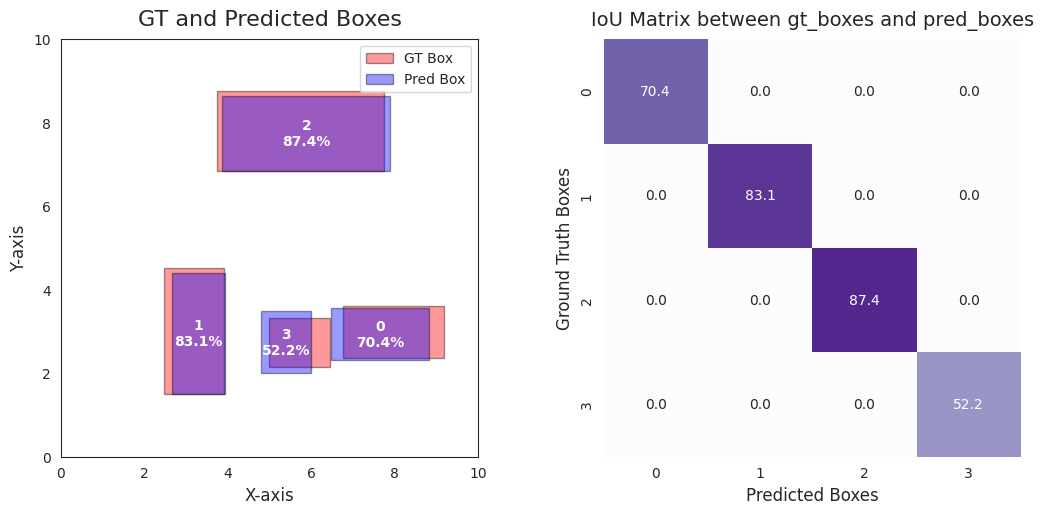

In [ ]:
def visualize_ious_and_boxes(gt_boxes, pred_boxes):

    ious = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, gt in enumerate(gt_boxes):
        for j, pred in enumerate(pred_boxes[:, :4]):
            ious[i, j] = iou(gt, pred)
    ious_percent = ious * 100  # Convert IoU values to percentages

    sns.set_style("white")  # Set clean background style

    # Create the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})

    # Left plot: Ground truth and predicted boxes
    ax1 = axes[0]
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.set_aspect('equal')
    ax1.set_title("GT and Predicted Boxes", fontsize=16, pad=10)
    ax1.set_xlabel("X-axis", fontsize=12)
    ax1.set_ylabel("Y-axis", fontsize=12)

    for gt in gt_boxes:
        y, x, h, w = gt
        ax1.add_patch(plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='black', facecolor='red', alpha=0.4, label='GT Box'))
    for j, pred in enumerate(pred_boxes):
        y, x, h, w, _ = pred
        ax1.add_patch(plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='black', facecolor='blue', alpha=0.4, label='Pred Box'))
        max_iou = np.max(ious[:, j]) * 100
        ax1.text(x + w / 2, y + h / 2, f"{j}\n{max_iou:.1f}%", color="white", ha="center", va="center", fontsize=10, weight="bold")

    handles, labels = ax1.get_legend_handles_labels()
    unique_handles_labels = {label: handle for handle, label in zip(handles, labels)}
    ax1.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper right', fontsize=10)

    # Right plot: IoU heatmap
    ax2 = axes[1]
    sns.heatmap(ious_percent, annot=True, fmt=".1f", cmap="Purples", vmin=0, vmax=100, ax=ax2, cbar=False)
    ax2.set_aspect('equal')
    ax2.set_title("IoU Matrix between gt_boxes and pred_boxes", fontsize=14, pad=10)
    ax2.set_xlabel("Predicted Boxes", fontsize=12)
    ax2.set_ylabel("Ground Truth Boxes", fontsize=12)

    # Adjust layout
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
    plt.show()


# Visualize IoUs
visualize_ious_and_boxes(gt_boxes, pred_boxes)


In [ ]:
class FocalLoss(Module):
    def __init__(self, gamma=2.0, reduction='mean'):
        super().__init__()
        # Store gamma as a non-trainable parameter
        self.gamma = Parameter(torch.tensor(gamma), requires_grad=False)
        self.reduction = reduction

    def forward(self, preds, targets):
        """
        preds: Tensor of shape (N, ...)
        targets: Tensor of the same shape, containing 0/1 labels
        """
        # Compute p_t
        p_t = torch.where(targets == 1, preds, 1 - preds)

        # Compute the focal term (1 - p_t)^gamma
        focal_factor = (1.0 - p_t).pow(self.gamma)

        # Apply focal weighting to the cross-entropy loss: -log(p_t)
        focal_loss = -focal_factor * torch.log(p_t + 1e-7)  # +1e-7 to avoid log(0)

        # Reduction: 'mean' or 'sum' (no reduction => 'none')
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Focal Loss Example
logits = torch.tensor([0.1, 0.5, 0.9, 0.3], dtype=torch.float32)
targets = torch.tensor([0, 1, 1, 0], dtype=torch.float32)

focal_loss = FocalLoss()
loss = focal_loss(logits, targets)
print(f"Focal Loss: {loss.item():.4f}")


Focal Loss: 0.0519


### 2. Average Prediction

Implement a function that computes the average precision. Use the point interpolation method (see updated lecture slides).
Compute the AP for `scored_detections`.


In [ ]:
scored_detections = [[78.4, True], [72.4, True], [65.1, False], [63.6, True], [63.4, True], [57.6, False], [54.6, False], [23.2, False], [12.2, True]]

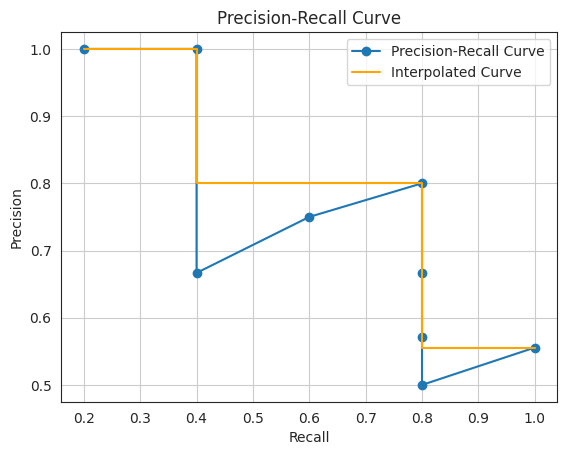

0.6311111111111112


In [ ]:
def average_precision(scored_detections, num_ground_truths, sorted=False, plot=False):

    # Sort detections by score in descending order if not already sorted
    if not sorted:
        scored_detections.sort(key=lambda x: x[0], reverse=True)

    # Calculate precision and recall at each detection
    tp = 0
    fp = 0
    pr_curve = []

    for score, is_correct in scored_detections:
        if is_correct:
            tp += 1
        else:
            fp += 1

        fn = num_ground_truths - tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        pr_curve.append((recall, precision))

    # Sort the curve by recall (ascending)
    pr_curve.sort(key=lambda x: x[0])

    # Interpolate and integrate the curve
    max_p = 0.0
    last_r = 1.0
    integrated_area = 0.0
    interpolated_points = []

    # Traverse from high recall to low (reverse)
    for r, p in reversed(pr_curve):
        integrated_area += (last_r - r) * max_p
        max_p = max(max_p, p)
        last_r = r
        interpolated_points.append((r, max_p))

    interpolated_points = np.array(interpolated_points)

    # Plot the precision-recall curve if requested
    if plot:
        recalls = [r for r, _ in pr_curve]
        precisions = [p for _, p in pr_curve]

        plt.figure()
        plt.plot(recalls, precisions, marker='o', label='Precision-Recall Curve')
        plt.step(interpolated_points[:, 0], interpolated_points[:, 1], where='post',
                 color='orange', label='Interpolated Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    return integrated_area

print(average_precision(scored_detections, num_ground_truths=5, plot=True))



### 3. Implement the Hungarian Loss

1. Implement a DETR detection head with 20 queries that uses the `features` tensor. Use your self-attention implementation from exercise 1 and adapt it for cross-attention.
2. Implement the hungarian loss. For simplicity, use the L1 loss as the distance (you might need to use the sigmoid function on your activations).  
   Use the Hungarian algorithm implementation from scipy.  
3. Train the cross-attention layer to match the 10 target boxes.  
**Hint:** Initializations are crucial, so check your initial predictions.


In [ ]:
query_tokens = torch.randn(20, 256)  # these go to query
feature_tokens = torch.rand(7,7,256)  # these go to keys and values


class TransformerDecoderLayerCrossOnly(nn.Module):
    def __init__(
        self,
        embedding_dim=48,
        hidden_dim=64,
        n_heads=4,
        device='cpu'
    ):
        super().__init__()
        self.device = device
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = embedding_dim // n_heads

        # --- Cross-attention projections ---
        self.q_proj = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.k_proj = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.v_proj = nn.Linear(embedding_dim, embedding_dim, bias=False)

        # --- 2-layer MLP ---
        self.fc1 = nn.Linear(embedding_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, embedding_dim, bias=True)

    def layer_norm(self, x, eps=1e-6):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, unbiased=False, keepdim=True)
        return (x - mean) / torch.sqrt(var + eps)

    def cross_attention(self, query, feaure):
        B, Q_len, D = query.shape
        _, M_len, _ = feaure.shape

        # 1) Project Q from query; K, V from feature
        Q = self.q_proj(query)    # [B, Q_len, D]
        K = self.k_proj(feaure)   # [B, M_len, D]
        V = self.v_proj(feaure)   # [B, M_len, D]

        # 2) Reshape for multi-head: [B, n_heads, seq_len, head_dim]
        Q = Q.view(B, Q_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(B, M_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(B, M_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # 3) Scaled dot-product attention:
        scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_dim)
        attn = scores.softmax(dim=-1)
        out = torch.matmul(attn, V)

        return out.permute(0, 2, 1, 3).contiguous().view(B, Q_len, D)

    def forward(self, query_tokens, feature_tokens):
        # --- Cross-Attention ---
        cross_att_out = self.cross_attention(query_tokens, feature_tokens)
        # Residual + LN
        x = self.layer_norm(query_tokens + cross_att_out)

        # --- 2-layer MLP ---
        # fc1 -> ReLU -> fc2
        mlp_out = self.fc1(x)
        mlp_out = mlp_out.clamp(min=0)  # manual ReLU
        mlp_out = self.fc2(mlp_out)

        # Another Residual + LN
        x = self.layer_norm(x + mlp_out)

        return x

# batch_size = 1 for simplicity
query_tokens = query_tokens.unsqueeze(0)

# Flatten the 7x7 feature map
feature_tokens = feature_tokens.view(7*7, 256)
feature_tokens = feature_tokens.unsqueeze(0)

decoder_layer = TransformerDecoderLayerCrossOnly(
    embedding_dim=256,
    hidden_dim=512,
    n_heads=8,
    device='cpu'
)

decoded_queries = decoder_layer(query_tokens, feature_tokens)

print(decoded_queries.size())


torch.Size([1, 20, 256])


Predicted Boxes: torch.Size([20, 4])
Confidence Scores: torch.Size([20, 1])


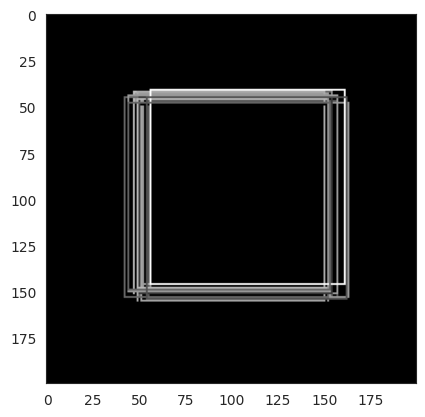

In [ ]:
class DETRHead(nn.Module):
    def __init__(self, in_dim=256, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # Output layers
        self.bbox_fc = nn.Linear(hidden_dim, 4)  # => [cx, cy, w, h]
        self.confidence_fc = nn.Linear(hidden_dim, 1)  # => confidence score

    def forward(self, x):
        # Simple 2-layer MLP
        x = self.fc1(x).clamp(min=0)
        x = self.fc2(x).clamp(min=0)

        pred_boxes = torch.sigmoid(self.bbox_fc(x))   # bounding box in [0,1]
        confidence_scores = torch.sigmoid(self.confidence_fc(x))  # confidence in [0,1]

        return pred_boxes, confidence_scores

# Example usage
bbox_head = DETRHead(256, 256)
decoded_queries = torch.randn(20, 256)  # Simulated input for 20 queries
pred_boxes, confidence_scores = bbox_head(decoded_queries)

print("Predicted Boxes:", pred_boxes.size())  # Should be [20, 4]
print("Confidence Scores:", confidence_scores.size())  # Should be [20, 1]



plt.imshow(draw_bounding_boxes(torch.zeros(3, 200, 200, dtype=torch.uint8),
                               200 * box_convert(pred_boxes, 'cxcywh', 'xyxy'),
                               colors=["rgb({},{},{})".format(*[int(255 * alpha)] * 3) for alpha in ((confidence_scores - confidence_scores.min()) / (confidence_scores.max() - confidence_scores.min()))]
                               ).permute(1, 2, 0))

In [ ]:
def l1_loss(pred_boxes, target_boxes):
    return torch.abs(pred_boxes - target_boxes).mean()

def hungarian_loss(pred_boxes, target_boxes, class_logits):

    if len(pred_boxes) == 0:
        raise ValueError
    if len(target_boxes) == 0:
        raise ValueError
    if len(class_logits) == 0:
        raise ValueError
    if len(pred_boxes) != len(class_logits):
        raise ValueError
    if len(pred_boxes) < len(target_boxes):
        raise ValueError



    loss_matrix = torch.zeros((pred_boxes.shape[0], pred_boxes.shape[0]))
    for i, pred_box in enumerate(pred_boxes):
        for j in range(pred_boxes.shape[0]):
            try:
                target_box = target_boxes[j]
                loss_matrix[i, j] = l1_loss(pred_box, target_box) - class_logits[i]
            except IndexError:
                loss_matrix[i, j] = class_logits[i]

    row_indices, col_indices = linear_sum_assignment(loss_matrix.detach().numpy())
    return loss_matrix[row_indices, col_indices].sum()

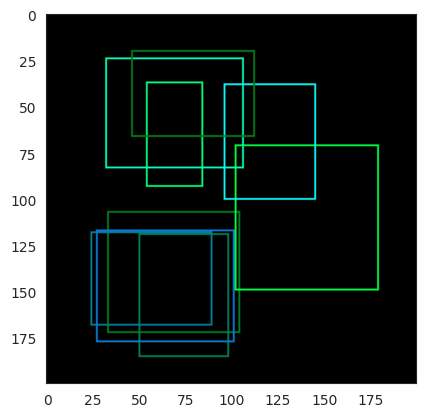

In [ ]:
c = 0.2+torch.rand(10, 2)*0.6
s = 0.1+torch.rand(10, 2)*0.3
targets = torch.cat([c,s], dim=1)
plt.imshow(draw_bounding_boxes(torch.zeros(3, 200,200), 200*box_convert(targets, 'cxcywh', 'xyxy')).permute(1,2,0))

In [ ]:
num_epochs = 1000

import torch.optim as optim

decoder = TransformerDecoderLayerCrossOnly(embedding_dim=256, hidden_dim=256, n_heads=4, device='cpu')
bbox_head = DETRHead(256, 256)

# Optimizer
optimizer = optim.Adam(list(decoder.parameters()) + list(bbox_head.parameters()), lr=1e-3)


for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    decoded_queries = decoder(query_tokens, feature_tokens)
    pred_boxes, confidence_scores = bbox_head(decoded_queries.squeeze(0))  # Remove batch dim

    # Compute loss
    loss = hungarian_loss(pred_boxes, targets, confidence_scores.squeeze(-1))

    # Backward pass
    loss.backward()
    optimizer.step()

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")




Epoch 0, Loss: 1.5174992084503174
Epoch 100, Loss: -9.925187110900879
Epoch 200, Loss: -9.911457061767578
Epoch 300, Loss: -9.945747375488281
Epoch 400, Loss: -9.936089515686035
Epoch 500, Loss: -9.953701972961426
Epoch 600, Loss: -9.948783874511719
Epoch 700, Loss: -9.962531089782715
Epoch 800, Loss: -9.959308624267578
Epoch 900, Loss: -9.958199501037598


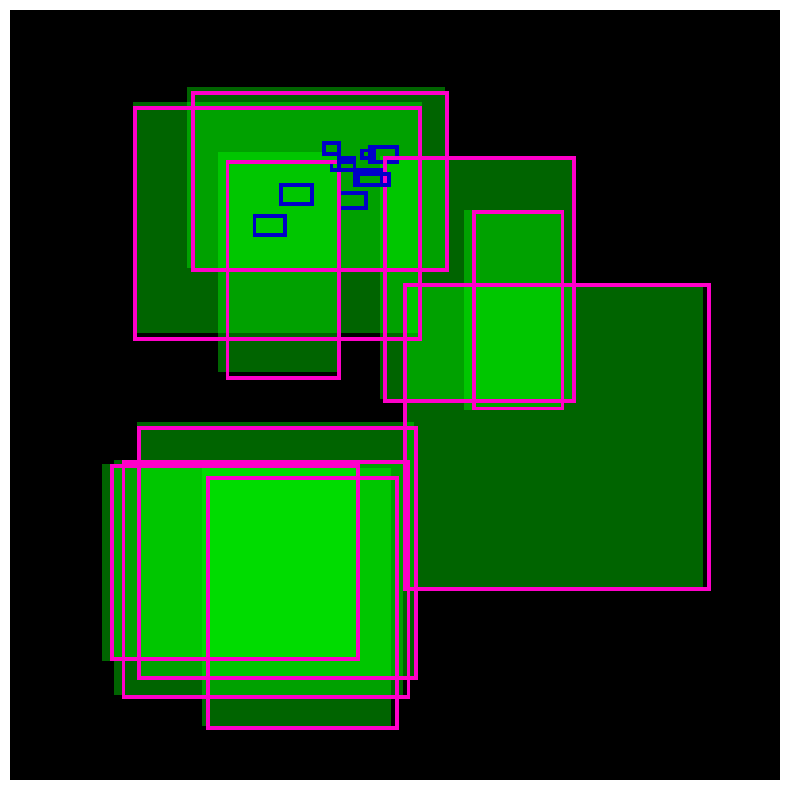

In [ ]:
# Evaluate the model
with torch.no_grad():
    decoded_queries = decoder(query_tokens, feature_tokens)
    pred_boxes, confidence_scores = bbox_head(decoded_queries.squeeze(0))  # Remove batch dim

plt.figure(figsize=(10, 10))
plt.imshow(
    draw_bounding_boxes(
        draw_bounding_boxes(
            torch.zeros(3, 200, 200, dtype=torch.uint8),  # Start with a blank canvas
            200 * box_convert(targets, 'cxcywh', 'xyxy'),  # Ground truth boxes
            colors="rgb(0,255,0)", # Targets in green
            width=0,
            fill="rgb(0,100,0)"
        ),
        200 * box_convert(pred_boxes, 'cxcywh', 'xyxy'),  # Predicted boxes
        colors=["rgb({},{},{})".format(int(255 * alpha), 0, 200) for alpha in (
            (confidence_scores - confidence_scores.min()) / (confidence_scores.max() - confidence_scores.min())
        )]
    ).permute(1, 2, 0)
)
plt.axis('off')
plt.show()



### 4. Object Detector Implementation and Training

#### Detector Implementation
Implement one of the following object detectors (or a combination of them): FCOS, CenterNet or RetinaNet.  
FCOS: https://openaccess.thecvf.com/content_ICCV_2019/papers/Tian_FCOS_Fully_Convolutional_One-Stage_Object_Detection_ICCV_2019_paper.pdf    
CenterNet: https://arxiv.org/pdf/1904.08189   
RetinaNet: https://arxiv.org/pdf/1708.02002v2.pdf  
Use a ResNet18 as a backbone. Don't forget to implement the FPN. You are free to use all of PyTorch (including `torch.nn`) and torchvision.

#### Detector Training
Train the detector on MS COCO selection.   
You can download the images here: http://images.cocodataset.org/zips/val2017.zip   
Upload your predictions on the test set to StudIP in the format defined below (`ex2_groupX_predictions.json`).  
**Note:** This is a fairly small training dataset of only 2000 images for detection, so don't expect state-of-the-art performance.

In [ ]:
resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

#!wget http://images.cocodataset.org/zips/val2017.zip
#!unzip val2017.zip

In [ ]:
subset_name = 'val2017'

img_size = 224
transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(img_size, antialias=True),
    v2.CenterCrop(img_size),
    v2.ToDtype(torch.float32, scale=True),
])

# Optional debug dataset calls—**not** used in final training
coco = CocoDetection( f'val2017', annFile=f'instances_course_train.json', transforms=transforms)
coco_test = CocoDetection( f'val2017', annFile=f'instances_course_test_no_annotations.json', transforms=transforms)
len(coco), len(coco_test)


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(2000, 361)

In [ ]:

def fcos_loss_multi_level(cls_outs, reg_outs, center_outs, targets, strides, image_size=(224, 224)):
    device = cls_outs[0].device
    N = cls_outs[0].shape[0]  # Batch size
    C = cls_outs[0].shape[1]  # Number of classes

    total_cls_loss = 0.0
    total_reg_loss = 0.0
    total_cent_loss = 0.0

    # Define scale ranges for FPN levels (adjust based on your dataset)
    scale_ranges = [
        (0, 32),     # p3
        (32, 64),    # p4
        (64, 128),   # p5
        (128, float('inf'))  # p6
    ]

    for cls_out, reg_out, center_out, stride, (scale_min, scale_max) in zip(cls_outs, reg_outs, center_outs, strides, scale_ranges):
        N, C, H, W = cls_out.shape

        # Flatten the outputs for easier processing
        cls_out_flat = cls_out.permute(0, 2, 3, 1).reshape(-1, C)         # [N*H*W, C]
        reg_out_flat = reg_out.permute(0, 2, 3, 1).reshape(-1, 4)         # [N*H*W, 4]
        center_out_flat = center_out.permute(0, 2, 3, 1).reshape(-1)     # [N*H*W]

        # Initialize target tensors
        cls_targets = torch.zeros_like(cls_out_flat, device=device)       # [N*H*W, C]
        reg_targets = torch.zeros_like(reg_out_flat, device=device)       # [N*H*W, 4]
        center_targets = torch.zeros_like(center_out_flat, device=device) # [N*H*W]
        pos_mask = torch.zeros(cls_out_flat.shape[0], dtype=torch.bool, device=device)  # [N*H*W]

        stride_h = image_size[0] / H
        stride_w = image_size[1] / W

        for b, tdict in enumerate(targets):
            boxes = tdict["boxes"]    # [num_boxes, 4]
            labels = tdict["labels"]  # [num_boxes]

            for box, label in zip(boxes, labels):
                x0, y0, bw, bh = box
                x1 = x0 + bw
                y1 = y0 + bh

                # Skip invalid boxes
                if bw <= 0 or bh <= 0:
                    continue

                # Calculate the size of the box (average of width and height)
                box_size = (bw + bh) / 2

                # Determine the appropriate FPN level for this box
                for level, (scale_min, scale_max) in enumerate(scale_ranges):
                    if scale_min < box_size <= scale_max:
                        assigned_level = level
                        break
                else:
                    # If box size exceeds all defined ranges, assign to the last level
                    assigned_level = len(scale_ranges) - 1

                # Proceed only if the current FPN level matches the assigned level
                try:
                    current_level = strides.index(stride)
                except ValueError:
                    # If stride is not found in strides list, skip this box
                    continue

                if current_level != assigned_level:
                    continue  # Skip this box for the current level

                # Compute the center of the box
                center_x = x0 + bw / 2
                center_y = y0 + bh / 2

                # Determine the corresponding feature map position
                grid_x = int(center_x // stride_w)
                grid_y = int(center_y // stride_h)

                # Clamp to feature map dimensions
                grid_x = max(0, min(grid_x, W - 1))
                grid_y = max(0, min(grid_y, H - 1))

                idx = b * (H * W) + grid_y * W + grid_x
                pos_mask[idx] = True
                if label < C:
                    cls_targets[idx, label] = 1.0

                # Compute distances for regression
                l = center_x - x0
                r = x1 - center_x
                t_ = center_y - y0
                b_ = y1 - center_y

                # Clamp distances to avoid negative values
                l = max(l, 1e-3)  # Avoid zero
                r = max(r, 1e-3)
                t_ = max(t_, 1e-3)
                b_ = max(b_, 1e-3)

                reg_targets[idx] = torch.tensor([l, t_, r, b_], device=device)

                # Compute centerness
                num_lr = min(l, r) * min(t_, b_)
                den_lr = max(l, r) * max(t_, b_)
                if den_lr == 0:
                    cval = 0.0
                else:
                    cval = torch.sqrt(num_lr / (den_lr + 1e-7))
                center_targets[idx] = cval

        # --- Classification Loss (Focal Loss) ---
        cls_loss = sigmoid_focal_loss(
            cls_out_flat,    # [N*H*W, C] raw logits
            cls_targets,     # [N*H*W, C] one-hot targets
            gamma=2.0,
            reduction="sum"
        )

        # --- Regression + Centerness (Only Positive Samples) ---
        pos_inds = pos_mask.nonzero(as_tuple=False).squeeze(1)  # Indices of positive samples
        if len(pos_inds) > 0:
            # Regression Loss (L1)
            pred_reg = reg_out_flat[pos_inds]          # [num_pos, 4]
            tgt_reg = reg_targets[pos_inds]           # [num_pos, 4]
            reg_loss = F.l1_loss(pred_reg, tgt_reg, reduction="sum")

            # Centerness Loss (Binary Cross Entropy)
            pred_center = center_out_flat[pos_inds]    # [num_pos]
            tgt_center = center_targets[pos_inds]     # [num_pos]
            cent_loss = F.binary_cross_entropy_with_logits(
                pred_center, tgt_center, reduction="sum"
            )
        else:
            reg_loss = torch.tensor(0.0, device=device)
            cent_loss = torch.tensor(0.0, device=device)

        # Combine losses for this level
        total_cls_loss += cls_loss
        total_reg_loss += reg_loss
        total_cent_loss += cent_loss

    # Combine all losses across all levels and normalize by batch size
    total_loss = (total_cls_loss + total_reg_loss + total_cent_loss) / N

    # Check for NaNs
    assert not torch.isnan(total_loss), "Total loss is NaN."

    return total_loss  # Return only the total loss

In [ ]:
class ResNet18FPN(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.stage1 = nn.Sequential(*list(backbone.children())[:5])  # Conv1 + BN + ReLU + MaxPool
        self.stage2 = nn.Sequential(*list(backbone.children())[5])   # Layer1
        self.stage3 = nn.Sequential(*list(backbone.children())[6])   # Layer2
        self.stage4 = nn.Sequential(*list(backbone.children())[7])   # Layer3

        # Feature Pyramid Network expects feature maps from different stages
        self.fpn = FeaturePyramidNetwork([64, 128, 256, 512], 256)

    def forward(self, x):
        c1 = self.stage1(x)  # [B,64,H1,W1]
        c2 = self.stage2(c1) # [B,128,H2,W2]
        c3 = self.stage3(c2) # [B,256,H3,W3]
        c4 = self.stage4(c3) # [B,512,H4,W4]

        features = {"c1": c1, "c2": c2, "c3": c3, "c4": c4}
        fpn_features = self.fpn(features)  # Outputs from FPN layers

        return fpn_features



class FCOSHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.cls_head = self._make_head()
        self.reg_head = self._make_head()
        self.centerness_head = self._make_head()
        self.cls_score = nn.Conv2d(256, num_classes, kernel_size=3, padding=1)
        self.bbox_pred = nn.Conv2d(256, 4, kernel_size=3, padding=1)
        self.centerness = nn.Conv2d(256, 1, kernel_size=3, padding=1)

    def _make_head(self):
        layers = []
        for _ in range(4):
            layers.append(nn.Conv2d(256, 256, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, features):
        cls_outputs = []
        reg_outputs = []
        centerness_outputs = []
        for feat in features.values():
            c = self.cls_head(feat)          # [B,256,H,W]
            r = self.reg_head(feat)          # [B,256,H,W]
            ce = self.centerness_head(feat)  # [B,256,H,W]
            cls_outputs.append(self.cls_score(c))          # [B,num_classes,H,W]
            reg_outputs.append(self.bbox_pred(r))          # [B,4,H,W]
            centerness_outputs.append(self.centerness(ce)) # [B,1,H,W]

        return cls_outputs, reg_outputs, centerness_outputs

class FCOS(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = ResNet18FPN()
        self.head = FCOSHead(num_classes)

    def forward(self, x):
        fpn_features = self.backbone(x)
        cls_outs, reg_outs, centerness_outs = self.head(fpn_features)
        return cls_outs, reg_outs, centerness_outs

# Dataset Loading and Collate Function
def load_coco_dataset(ann_file, img_dir, transform):
    coco = COCO(ann_file)

    class CocoDataset(torch.utils.data.Dataset):
        def __init__(self, coco, img_dir, transform):
            self.coco = coco
            self.ids = list(coco.imgs.keys())
            self.img_dir = img_dir
            self.transform = transform

        def __len__(self):
            return len(self.ids)

        def __getitem__(self, idx):
            img_id = self.ids[idx]
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)

            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            img = Image.open(img_path).convert('RGB')

            boxes = []
            labels = []
            for ann in anns:
                # Each ann['bbox'] = [x, y, w, h]
                boxes.append(ann['bbox'])
                labels.append(ann['category_id'])

            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64)
            }

            if self.transform:
                img = self.transform(img)

            return img, target

    return CocoDataset(coco, img_dir, transform)

def collate_fn(batch):
    images = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    return images, targets

In [ ]:
def train_detector_multi_level(model, dataloader, optimizer, device, strides, image_size=(224,224)):
    model.train()
    total_loss = 0.0

    for images, targets in tqdm(dataloader, desc="Training"):
        # Move images to device and stack into a batch tensor
        images = torch.stack(images).to(device, non_blocking=True)

        # Process targets: Convert list of annotations to dict with 'boxes' and 'labels'
        processed_targets = []
        for t in targets:
            boxes = [ann['bbox'] for ann in t]
            labels = [ann['category_id'] for ann in t]

            if boxes:
                boxes = torch.tensor(boxes, dtype=torch.float32)
                labels = torch.tensor(labels, dtype=torch.int64)
            else:
                boxes = torch.empty((0, 4), dtype=torch.float32)
                labels = torch.empty((0,), dtype=torch.int64)

            processed_target = {
                "boxes": boxes.to(device, non_blocking=True),
                "labels": labels.to(device, non_blocking=True)
            }
            processed_targets.append(processed_target)

        optimizer.zero_grad()

        # Forward pass without mixed precision
        cls_outs, reg_outs, centerness_outs = model(images)
        loss = fcos_loss_multi_level(cls_outs, reg_outs, centerness_outs, processed_targets, strides=strides, image_size=image_size)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [ ]:
num_classes = 80  # MS COCO has 80 classes
model = FCOS(num_classes)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

# Create DataLoader for the subset
batch_size = 4
num_workers = 4
dataloader = DataLoader(
    coco,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True
)


strides = [8, 16, 32, 64]

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Number of epochs
epochs = 10

# List to store average loss for each epoch
loss_history = []

# Training loop
for epoch in range(epochs):
    avg_loss = train_detector_multi_level(model, dataloader, optimizer, device, strides=strides, image_size=(224,224))
    print(f"[Epoch {epoch+1}/{epochs}] Avg Loss = {avg_loss:.4f}")
    loss_history.append(avg_loss)



Using device: cuda:0


Training: 100%|██████████| 500/500 [00:45<00:00, 11.00it/s]


[Epoch 1/10] Avg Loss = 892.4274


Training: 100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


[Epoch 2/10] Avg Loss = 399.9486


Training: 100%|██████████| 500/500 [00:44<00:00, 11.14it/s]


[Epoch 3/10] Avg Loss = 373.4103


Training: 100%|██████████| 500/500 [00:45<00:00, 10.99it/s]


[Epoch 4/10] Avg Loss = 356.2947


Training: 100%|██████████| 500/500 [00:44<00:00, 11.14it/s]


[Epoch 5/10] Avg Loss = 337.2287


Training: 100%|██████████| 500/500 [00:45<00:00, 11.10it/s]


[Epoch 6/10] Avg Loss = 323.4558


Training: 100%|██████████| 500/500 [00:44<00:00, 11.13it/s]


[Epoch 7/10] Avg Loss = 303.1300


Training: 100%|██████████| 500/500 [00:44<00:00, 11.19it/s]


[Epoch 8/10] Avg Loss = 280.8031


Training: 100%|██████████| 500/500 [00:44<00:00, 11.13it/s]


[Epoch 9/10] Avg Loss = 273.0001


Training: 100%|██████████| 500/500 [00:45<00:00, 11.10it/s]

[Epoch 10/10] Avg Loss = 257.5068


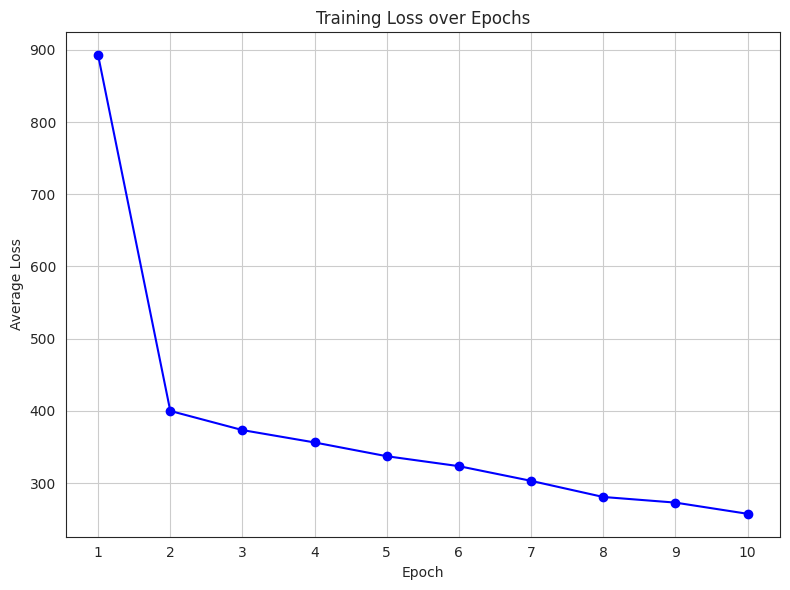

In [ ]:
# Plotting the loss across epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), loss_history, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.xticks(range(1, epochs+1))
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
def predict_and_save(model, test_dataset, device, strides, image_size=(224,224),
                    score_threshold=0.5, iou_threshold=0.5, max_predictions_per_class=100,
                    output_file='ex2_group3_prediction.json'):
    model.eval()
    predictions = []
    total_images = len(test_dataset)

    with torch.no_grad():
        for idx in tqdm(range(total_images), desc="Predicting"):
            img, _ = test_dataset[idx]  # target can be ignored for test set
            img = img.unsqueeze(0).to(device)  # Add batch dimension

            # Forward pass
            cls_outs, reg_outs, centerness_outs = model(img)

            # Initialize predictions for this image
            image_predictions = []

            # Iterate over each FPN level
            for cls_out, reg_out, cent_out, stride in zip(cls_outs, reg_outs, centerness_outs, strides):
                # Apply sigmoid to classification and centerness outputs
                cls_scores = torch.sigmoid(cls_out)          # [1, C, H, W]
                cent_scores = torch.sigmoid(cent_out)        # [1, 1, H, W]

                # Multiply classification scores with centerness
                combined_scores = cls_scores * cent_scores    # [1, C, H, W]

                # Flatten the tensors
                combined_scores = combined_scores.squeeze(0).permute(1, 2, 0).reshape(-1, cls_scores.shape[1])  # [H*W, C]
                reg_out_flat = reg_out.squeeze(0).permute(1, 2, 0).reshape(-1, 4)                                  # [H*W, 4]

                # For each class, filter out low scores and apply NMS
                for class_idx in range(cls_scores.shape[1]):
                    scores = combined_scores[:, class_idx]  # [H*W]
                    mask = scores > score_threshold
                    if mask.sum() == 0:
                        continue
                    scores = scores[mask]
                    regs = reg_out_flat[mask]

                    # Compute center coordinates
                    H, W = cls_out.shape[2], cls_out.shape[3]
                    ys = torch.arange(0, H, device=device).float() * stride + stride / 2
                    xs = torch.arange(0, W, device=device).float() * stride + stride / 2
                    grid_x, grid_y = torch.meshgrid(xs, ys, indexing='xy')  # Explicit indexing
                    grid_x = grid_x.flatten()[mask]
                    grid_y = grid_y.flatten()[mask]

                    # Compute box coordinates in [x1, y1, x2, y2] format
                    l = regs[:, 0]
                    t_ = regs[:, 1]
                    r = regs[:, 2]
                    b_ = regs[:, 3]
                    x_min = grid_x - l
                    y_min = grid_y - t_
                    x_max = grid_x + r
                    y_max = grid_y + b_

                    boxes = torch.stack([x_min, y_min, x_max, y_max], dim=1)  # [num_boxes, 4]

                    # Apply NMS
                    keep = nms(boxes, scores, iou_threshold)
                    boxes = boxes[keep]
                    scores = scores[keep]

                    # Limit the number of predictions per class
                    if len(keep) > max_predictions_per_class:
                        topk = max_predictions_per_class
                        boxes = boxes[:topk]
                        scores = scores[:topk]

                    # Convert boxes back to [x, y, w, h] format
                    widths = boxes[:, 2] - boxes[:, 0]
                    heights = boxes[:, 3] - boxes[:, 1]
                    boxes_xywh = torch.stack([boxes[:, 0], boxes[:, 1], widths, heights], dim=1)

                    # Append to image predictions
                    for box, score in zip(boxes_xywh, scores):
                        prediction = {
                            "image_id": test_dataset.ids[idx],
                            "category_id": class_idx + 1,  # COCO categories are 1-indexed
                            "bbox": box.cpu().tolist(),     # [x, y, w, h]
                            "score": score.cpu().item()
                        }
                        image_predictions.append(prediction)

            # Optionally, limit the total number of predictions per image
            if len(image_predictions) > 100:
                # Sort by score in descending order and keep top 100
                image_predictions = sorted(image_predictions, key=lambda x: x['score'], reverse=True)[:100]

            predictions.extend(image_predictions)

    # Save predictions to JSON
    with open(output_file, 'w') as f:
        json.dump(predictions, f)

    print(f"Saved predictions to {output_file}")


In [ ]:
# Run prediction and save results
predict_and_save(
    model=model,
    test_dataset=coco_test,
    device=device,
    strides=strides,
    image_size=(224,224),
    score_threshold=0.5,   # Increased threshold to reduce low-confidence predictions
    iou_threshold=0.5,      # IoU threshold for NMS
    max_predictions_per_class=100,
    output_file='ex2_group3_prediction.json'
)


Predicting: 100%|██████████| 361/361 [00:15<00:00, 23.65it/s]

Saved predictions to ex2_group3_prediction.json
